###  Created by Luis Alejandro (alejand@umich.edu)

Simple exploration of extraction techniques and some brief comparison

**Install the following packages:**

pip install npTDMS<br>
pip install mysql-connector-python<br>
pip install librosa

In [1]:
import nptdms
import librosa
import librosa.display
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
from scipy.signal import decimate

In [2]:
def preprocess(data,fs,factor=6):
    data = decimate(data,factor)
    fs = int(fs/factor)
    return data,fs

def get_spectrogram(data,fs,n_fft=1024,hop_length=512,n_mels=128):
    data,fs = preprocess(data,fs,factor=6)
    spec = librosa.feature.melspectrogram(np.asfortranarray(data),sr=fs,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels)
    spec = librosa.power_to_db(spec)
    return spec

In [3]:
# Connect to DB
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = "cuba",
    database = "airnoise"
)
print(mydb)

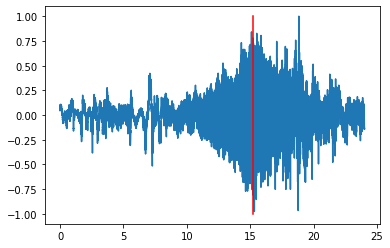

In [4]:
dbcursor = mydb.cursor()
fs = 51200
measurement = 15
array = 1
microphone = 1
sql = '''SELECT m.url, t.location FROM tmid t, measurements m WHERE t.measurement = {} AND
    t.array = {} AND t.microphone = {} AND m.id_measurement = t.measurement'''.format(
    measurement,array,microphone)
dbcursor.execute(sql)
result = dbcursor.fetchall()
url = result[0][0]
tmid = result[0][1]
tdms = nptdms.TdmsFile("../../datasets/classification/noise/" + url)
data = tdms.channel_data(group = 'Untitled', channel = 'cDAQ1Mod' + str(array) + '/ai' + str(microphone - 1))
data = data / np.absolute(data).max()
time = np.arange(len(data)) / fs
plt.plot(time, data)
plt.plot([tmid,tmid],[-1,1],'r-')

In [5]:
offset = 0
expand = 5
start = int((tmid+offset-expand)*fs)
end = int((tmid+offset+expand)*fs)
segment = data[start:end+1]

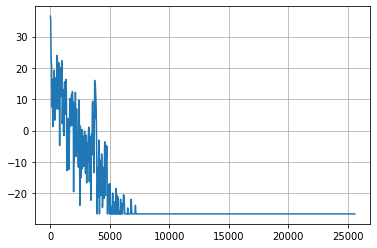

In [6]:
amp_spectrum = np.abs(librosa.stft(segment,n_fft=2048))
amp_spectrum = librosa.amplitude_to_db(amp_spectrum)
f = np.arange(1024 + 1)*((fs/2048))
plt.plot(f,amp_spectrum[:,0])
plt.grid()

(128, 167)

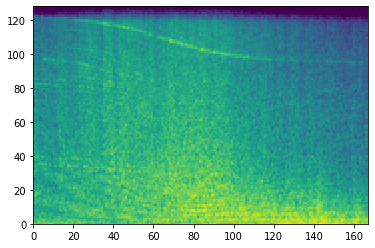

In [7]:
spec = get_spectrogram(segment,fs,n_fft=1024,hop_length=512,n_mels=128)
plt.pcolormesh(spec,cmap='viridis')
spec.shape

(128, 84)

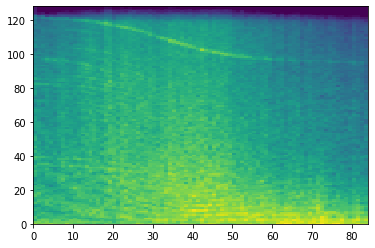

In [8]:
spec = get_spectrogram(segment,fs,n_fft=2048,hop_length=1024,n_mels=128)
plt.pcolormesh(spec,cmap='viridis')
spec.shape

In [9]:
%%timeit
lpc = librosa.core.lpc(segment,100)

436 ms ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
librosa.feature.mfcc(segment,100)

43.5 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
spec = get_spectrogram(segment,fs,n_fft=2048,hop_length=1024,n_mels=128)

25.7 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
